In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#!pip3 install git+https://github.com/huggingface/transformers
!pip3 install transformers==3.3.1
!pip3 install torchtext==0.2.1

In [3]:
%cd drive/My\ Drive/School\ Work/Fourth\ Year/Capstone\ Everything

/content/drive/My Drive/School Work/Fourth Year/Capstone Everything


In [4]:
# Libraries

import matplotlib.pyplot as plt
import pandas as pd
import torch

# Preliminaries

from torchtext.data import Field, TabularDataset, BucketIterator, Iterator

# Models

import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [ ]:
data_path = "./Models/Experiments/Claims/3epochs"
destination_path = "./Models/Experiments/Claims/3epochs/BertClassifierModel"
#destination_path = "./Models/BertClassifierModel/AbstractGenerator2Epoch"

In [ ]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'

Training Preparation

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
# Model parameter
MAX_SEQ_LEN = 256
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# Fields
# define the fields for the dataset object from Pytorch for training
label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
claims_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('Claims', claims_field), ('Label', label_field)]


In [ ]:
# TabularDataset
# TabularDataset is an object from Pytorch that allows us to easily conduct batch training when we deal with large datasets
train, valid, test = TabularDataset.splits(path=data_path, train='train.csv', validation='valid.csv',
                                           test='test.csv', format='CSV', fields=fields, skip_header=True)

Token indices sequence length is longer than the specified maximum sequence length for this model (735 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (723 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (574 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (562 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1063 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

In [ ]:
# Iterators

train_iter = BucketIterator(train, batch_size=16, sort_key=lambda x: len(x.Claims),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=16, sort_key=lambda x: len(x.Claims),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter = Iterator(test, batch_size=16, device=device, train=False, shuffle=False, sort=False)



In [ ]:
len(train_iter)

758

Model Construction

In [ ]:
# the text classifier architecture (We just need the BertForSequenceClassification model from Hugging Face)

class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        options_name = "bert-base-uncased" # the specific model that we want
        self.encoder = BertForSequenceClassification.from_pretrained(options_name)

    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]

        return loss, text_fea

Training

In [ ]:
# Save and Load Functions

def save_checkpoint(save_path, model, valid_loss):
    # This helper function allows us to save the model after a given point, it records the validation lost and the 
    # parameters (stored in model.state_dict()).
    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    # This is a helper functio nthat loads the model
    if load_path==None:
        return
    # load the parameters from the model stored in load_path
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    # we add the parameters to the model architecture, we need to make sure that the model is the same as the one that the parameters were save from
    # otherwise, we can't successfully load the model
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):
    # this helps us save the losses during training
    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):
    # this loads the metrics so we can graph and track them
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [ ]:
# Training Function

def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = destination_path,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []
    print("start training")
    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (Claim, Label), _ in train_loader:
            Label = Label.type(torch.LongTensor)           
            Label = Label.to(device)
            Claim = Claim.type(torch.LongTensor)  
            Claim = Claim.to(device)
            output = model(Claim, Label)
            loss, _ = output

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    

                    # validation loop
                    for (Claim, Label), _ in valid_loader:
                        Label = Label.type(torch.LongTensor)           
                        Label = Label.to(device)
                        Claim = Claim.type(torch.LongTensor)  
                        Claim = Claim.to(device)
                        output = model(Claim, Label)
                        loss, _ = output
                        
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

In [ ]:
bert_model = BERT()
model = bert_model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5) # change learning rates

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
train(model=model, optimizer=optimizer, file_path=destination_path)

start training
Epoch [1/5], Step [379/3790], Train Loss: 0.6390, Valid Loss: 0.5275
Model saved to ==> ./Models/Experiments/Claims/3epochs/BertClassifierModel/model.pt
Model saved to ==> ./Models/Experiments/Claims/3epochs/BertClassifierModel/metrics.pt
Epoch [1/5], Step [758/3790], Train Loss: 0.2700, Valid Loss: 0.8267
Epoch [2/5], Step [1137/3790], Train Loss: 0.3600, Valid Loss: 0.4297
Model saved to ==> ./Models/Experiments/Claims/3epochs/BertClassifierModel/model.pt
Model saved to ==> ./Models/Experiments/Claims/3epochs/BertClassifierModel/metrics.pt
Epoch [2/5], Step [1516/3790], Train Loss: 0.1119, Valid Loss: 0.2959
Model saved to ==> ./Models/Experiments/Claims/3epochs/BertClassifierModel/model.pt
Model saved to ==> ./Models/Experiments/Claims/3epochs/BertClassifierModel/metrics.pt
Epoch [3/5], Step [1895/3790], Train Loss: 0.2019, Valid Loss: 0.2830
Model saved to ==> ./Models/Experiments/Claims/3epochs/BertClassifierModel/model.pt
Model saved to ==> ./Models/Experiments/Cla

Model loaded from <== ./Models/Experiments/Claims/3epochs/BertClassifierModel/metrics.pt


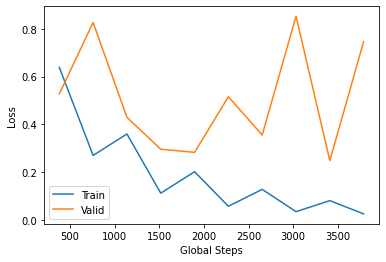

In [ ]:
# after loading the metrics, we can graph it to monitor when overfitting occurs
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_path + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

Evaluation

In [ ]:
# Evaluation Function

def evaluate(model, test_loader):
    '''
    The evaluation function loads uses the fine-tuned classification model and 
    runs it against the test set to evaluate how well the model performs 
    in distinguishing real and fake patent data that the model haven't seen before
    '''
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (Claim, Label), _ in test_loader:

                Label = Label.type(torch.LongTensor)           
                Label = Label.to(device)
                Claim = Claim.type(torch.LongTensor)  
                Claim = Claim.to(device)
                output = model(Claim, Label)

                _, output = output
                y_pred.extend(torch.argmax(output, 1).tolist())
                y_true.extend(Label.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[0,1], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['Real', 'Fake'])
    ax.yaxis.set_ticklabels(['Real', 'Fake'])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== ./Models/Experiments/Claims/3epochs/BertClassifierModel/model.pt
Classification Report:
              precision    recall  f1-score   support

           0     0.9359    0.9359    0.9359       842
           1     0.9359    0.9359    0.9359       842

    accuracy                         0.9359      1684
   macro avg     0.9359    0.9359    0.9359      1684
weighted avg     0.9359    0.9359    0.9359      1684



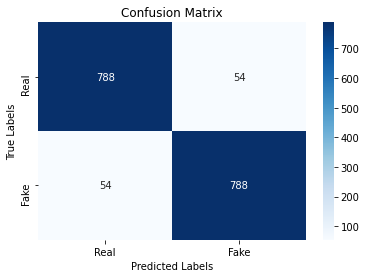

In [ ]:
best_model = BERT().to(device)

load_checkpoint(destination_path + '/model.pt', best_model)

evaluate(best_model, test_iter)

Classification Report:
              precision    recall  f1-score   support

           0     0.9234    0.9459    0.9345      1516
           1     0.9446    0.9215    0.9329      1516

    accuracy                         0.9337      3032
   macro avg     0.9340    0.9337    0.9337      3032
weighted avg     0.9340    0.9337    0.9337      3032



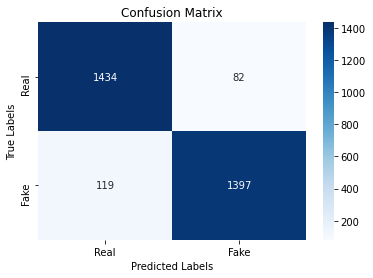

In [ ]:
# evaluate the validation data
evaluate(best_model, valid_iter)